# Time Series Modeling the S&P 500

This notebook investigates how well an ARIMA (auto-regressive integrated moving average) model may predicting the continous values of the stock market. 

##### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix, mean_absolute_error, mean_squared_error,\
mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm

import datetime as dt

# New import of my custom class
from classification_classes import Model, Importance

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

# Data

In [3]:
# Load the S&P Data
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(2)

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,...,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1964-02-06,^GSPC,76.93,76.93,77.260002,76.470001,0.0,4110000.0,669.822,3.50,0.0024,0.0006,-0.0023,0.0004,0.0006,NaN,64.329769,...,316.1823,1,2,4,Thursday,1964-03-06,1964-05-06,1964-08-06,1965-02-08,0.017938,0.053685,0.057325,0.130248,1.0,1.0,1.0,1.0
1,1964-02-07,^GSPC,77.18,77.18,77.510002,76.660004,0.0,4710000.0,669.822,3.52,0.0037,-0.0006,0.0014,0.0008,0.0036,NaN,68.197375,...,363.5178,1,2,4,Friday,1964-03-09,1964-05-07,1964-08-07,1965-02-08,0.014900,0.051438,0.060637,0.126587,1.0,1.0,1.0,1.0


In [4]:
# Prepare the dataframe appropriately
df['Date'] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Quarter"] = df["Quarter"].astype(str)
df['Month'] = df['Month'].astype(str)
df['cycle_year'] = df['cycle_year'].astype(str)
# Isolate S&P 500 index
df = df[df['Ticker'] == "^GSPC"]

In [7]:
df.shape

(14634, 40)

In [6]:
df.head()

,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,...,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1964-02-06,^GSPC,76.930000,76.930000,77.260002,76.470001,0.0,4110000.0,669.822,3.50,0.0024,0.0006,-0.0023,0.0004,0.0006,NaN,64.329769,76.168076,...,316.1823,1,2,4,Thursday,1964-03-06,1964-05-06,1964-08-06,1965-02-08,0.017938,0.053685,0.057325,0.130248,1.0,1.0,1.0,1.0
1964-02-07,^GSPC,77.180000,77.180000,77.510002,76.660004,0.0,4710000.0,669.822,3.52,0.0037,-0.0006,0.0014,0.0008,0.0036,NaN,68.197375,76.234617,...,363.5178,1,2,4,Friday,1964-03-09,1964-05-07,1964-08-07,1965-02-08,0.014900,0.051438,0.060637,0.126587,1.0,1.0,1.0,1.0
1964-02-10,^GSPC,77.050003,77.050003,77.769997,76.830002,0.0,4150000.0,669.822,3.53,-0.0013,0.0017,-0.0020,0.0013,-0.0016,NaN,64.376738,76.331949,...,319.7575,1,2,4,Monday,1964-03-10,1964-05-11,1964-08-10,1965-02-10,0.019987,0.049968,0.061389,0.122128,1.0,1.0,1.0,1.0
1964-02-11,^GSPC,77.330002,77.330002,77.650002,76.809998,0.0,4040000.0,669.822,3.52,0.0033,-0.0003,-0.0014,0.0021,0.0038,NaN,68.391587,76.385595,...,312.4132,1,2,4,Tuesday,1964-03-11,1964-05-11,1964-08-11,1965-02-11,0.020949,0.046166,0.057287,0.106168,1.0,1.0,1.0,1.0
1964-02-13,^GSPC,77.519997,77.519997,77.930000,77.099998,0.0,4820000.0,669.822,3.52,0.0008,-0.0001,-0.0007,0.0013,-0.0029,NaN,69.894212,76.383568,...,373.6464,1,2,4,Thursday,1964-03-13,1964-05-13,1964-08-13,1965-02-15,0.020898,0.044505,0.063081,0.110294,1.0,1.0,1.0,1.0


### Historical chart using 30-session rolling average

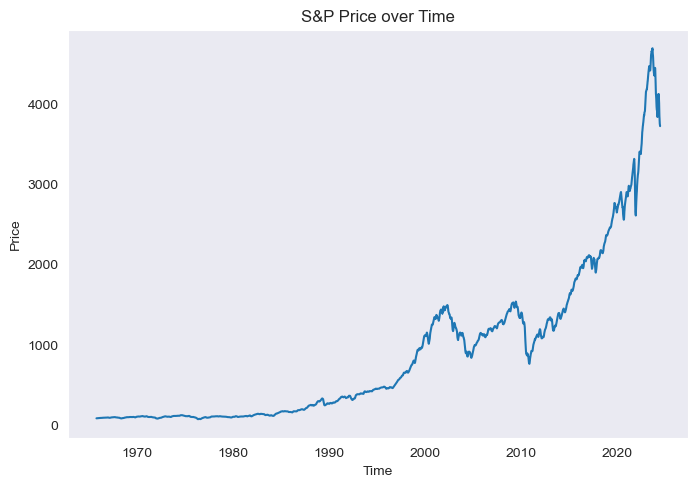

In [8]:
df["Adj Close"].rolling(30).mean().plot(title="S&P Price over Time", ylabel="Price", xlabel="Time", rot=0, figsize=(8,6));

# Univariate Timeseries Forecasting using ARIMA models
Typical order of determination:
- "I" test for and find stationarity component ADF test (Augmented Dickey Fuller)
- "AR" find the order of/optimal auto-regressive unit/term | the number of lags used as predictors, found via PACF plot
- "MA" find the order of the moving average term | the number of lagged errors regressed over, found via ACF plot

### AR = "auto-regressive" - (p)
The AR model is a linear regression that uses its own lags as predictors. Linear regression obviously works best when features are independent.
### I = "Integrated" (d)
This is the component of stationarity. This is the term for the number of "differencing" required to make our value stationary.
### MA = Moving Average
The "moving average" in this context doesn't refer to the traditional concept of averaging over a set of values. Instead, it's about the weighted sum of residuals in the time series. The idea is to capture and model the influence of past errors on the current value of the time series.

# "AR"
### The the confidence interval is set to .05 and  -.05, if the point is outside the cone, it is significant

- because all values are near one, nearly all of the value at obs 20 is impacted by previous values


In [12]:
# Creating univariate features
price = df[["Adj Close"]]
price_diff = df[["Adj Close"]].diff().dropna()

# Interpreting plots:
We are looking for the last positive value before a drop-off. That indicates the number of lags that should be included in our model. The PACF is used to find our AR "p" term, whereas the ACF is used to determine the MA "q" term.

### Pre-differenced data

### ACF

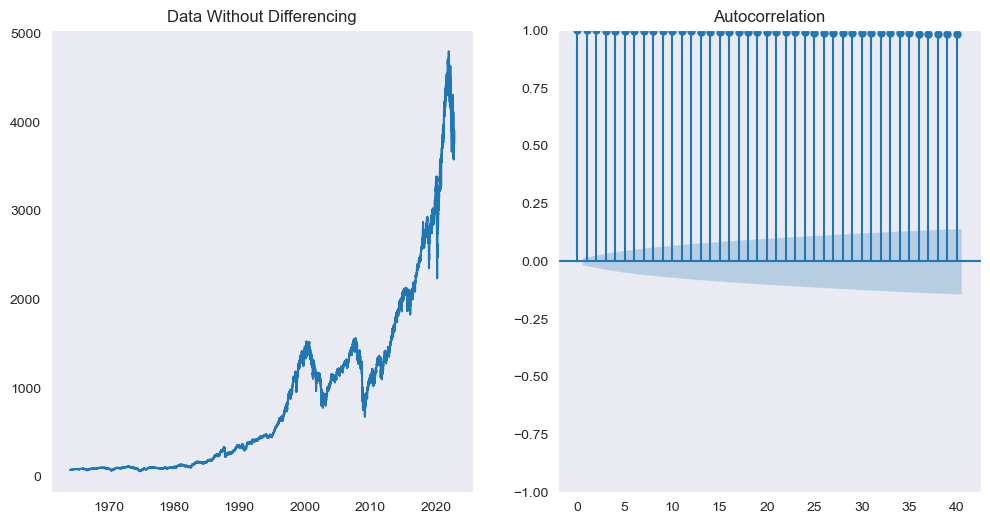

In [16]:
# Plotting the data and ACF functions in pursuit of 'q'
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(price)
ax[0].set_title("Data Without Differencing")
plot_acf(price["Adj Close"], ax=ax[1], lags=40);

### PACF

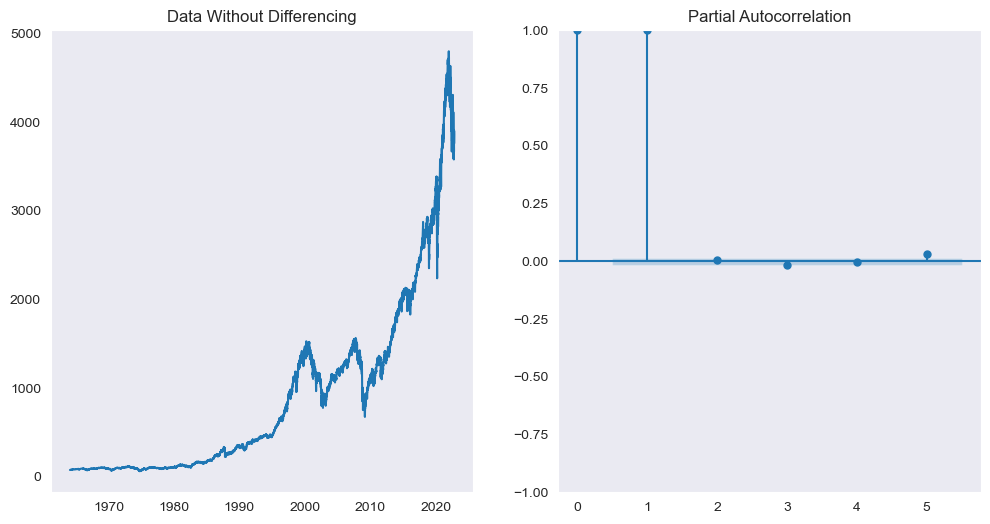

In [17]:
# Plotting PACF in pursuit of 'p', chart indicates 1 may be the appropriate term
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(price)
ax[0].set_title("Data Without Differencing")
plot_pacf(price, ax=ax[1], lags=5);

### Differenced Data

### ACF

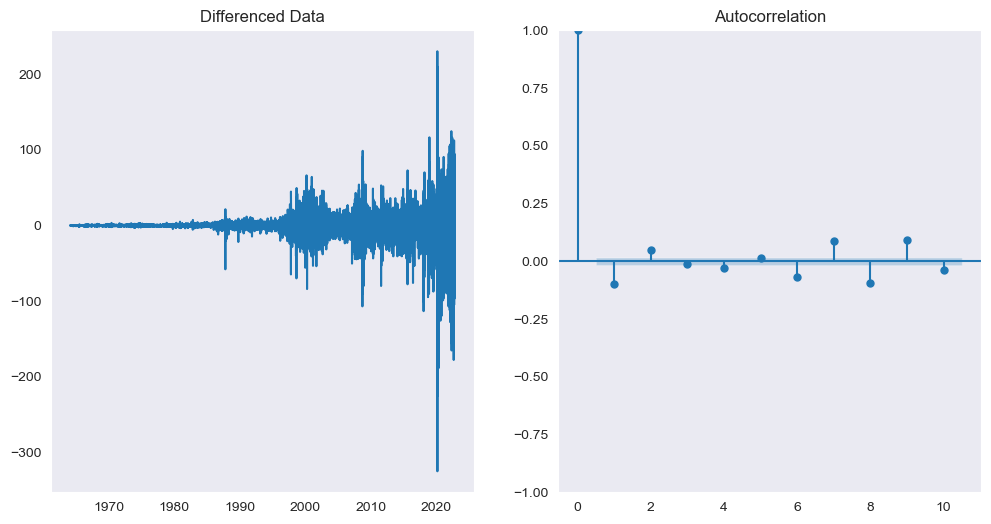

In [814]:
# Differenced data in pursuit of the "q" term, indicates 0 may be the value
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(price_diff)
ax[0].set_title("Differenced Data")
plot_acf(price_diff, ax=ax[1], lags=10, zero=True);

### PACF

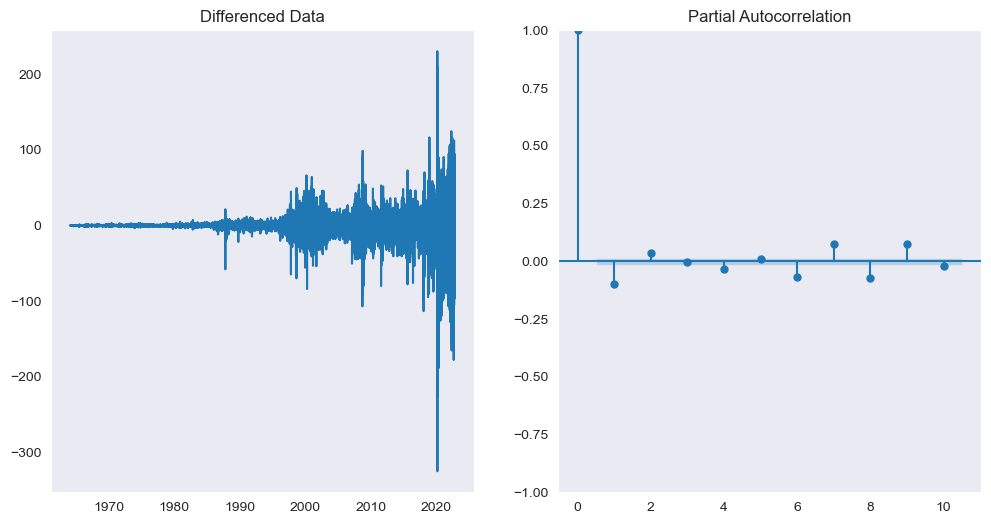

In [817]:
# Plotting the PACF, indicates 0, 1, 6, 8, could all be significant

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(price_diff)
ax[0].set_title("Differenced Data")
plot_pacf(price_diff, ax=ax[1], lags=10);

# "I" for Integrated | "q" term

### Stationarity Test - function and differencing iterations
In order to achieve stationarity, the values of the time series may need to be differenced.

### Function to return results

In [25]:
# Perform Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
def adfuller_results(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'usedlag: {result[2]}')
    print(f'nobs: {result[3]}')
    print(f'critical values: 1% {result[4]["1%"]} | 5%{result[4]["5%"]} | 10% {result[4]["10%"]}')
    print(f'icbest: {result[5]}')

# If the p-value is greater than 0.05, differencing may be needed.

In [26]:
# Shows the statistical p-value is too-high, and differencing must occur
adfuller_results(df["Adj Close"])

ADF Statistic: 1.8049111688780146
p-value: 0.9983587079935302
usedlag: 42
nobs: 14591
critical values: 1% -3.4307982524027345 | 5%-2.861738107762796 | 10% -2.56687544805126
icbest: 121044.9894806342


In [27]:
# First difference - statistical p-value of 0 indicates that the data has been made stationary
first_difference = df['Adj Close'].diff().dropna()

# ADF test on first difference
adfuller_results(first_difference)

ADF Statistic: -20.211792231573565
p-value: 0.0
usedlag: 41
nobs: 14591
critical values: 1% -3.4307982524027345 | 5%-2.861738107762796 | 10% -2.56687544805126
icbest: 121038.96643389695


In [34]:
first_difference.mean()

0.251674977181786

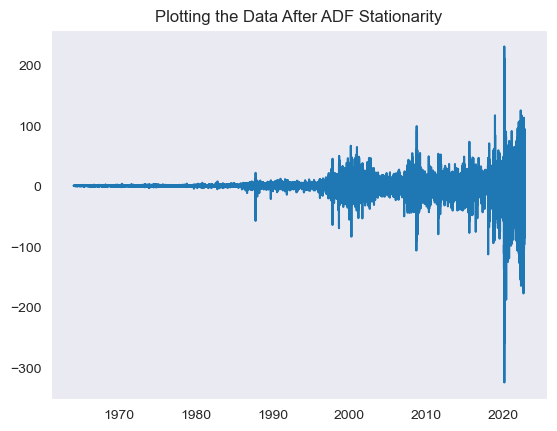

In [29]:
# After one "differencing", the plot looks to be stationary around a mean of 0.252, but variance increases
plt.plot(first_difference)
plt.title("Plotting the Data After ADF Stationarity");

# "MA" (q)

### Finding the best value for q given guessed p and known d values

In [30]:
# Cell takes several minutes to run

# Iterate over different values of q and select the one with the lowest AIC

best_aic = float('inf')
best_q = None

for q_candidate in range(4, 10):
    model = ARIMA(df["Adj Close"], order=(6, 1, q_candidate), )
    results = model.fit()
    aic = results.aic

    if aic < best_aic:
        best_aic = aic
        best_q = q_candidate

print(f"Best 'q' component based on AIC: {best_q}")

Best 'q' component based on AIC: 8


<hr style="border: 2px solid blue">

# First Model
### Model values for p,d,q based on analysis

In [31]:
# Fitting the uni-variate model with the appropriate terms

ar = ARIMA(endog=price["Adj Close"], order=(6, 1, 8))
results = ar.fit()

In [32]:
# inspecting the results of the model, looking at statistical significance of the model's coefficients
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                14634
Model:                 ARIMA(6, 1, 8)   Log Likelihood              -60724.821
Date:                Tue, 14 Nov 2023   AIC                         121479.642
Time:                        19:33:04   BIC                         121593.508
Sample:                             0   HQIC                        121517.467
                              - 14634                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9409      0.046    -20.643      0.000      -1.030      -0.852
ar.L2         -0.1716      0.039     -4.388      0.000      -0.248      -0.095
ar.L3         -0.0092      0.026     -0.355      0.723      -0.060       0.041
ar.L4         -0.6493      0.018    -36.987      0.000      -0.684      -0.615
ar.L5         -0.8947      0.046    -19.422      0.000      -0.985      -0.804
ar.L6         -0.5609      0.029    -19.151      0.000      -0.618      -0.503
ma.L1          0.8619      0.046     18.914      0.000       0.773       0.951
ma.L2          0.1276      0.036      3.499      0.000       0.056       0.199
ma.L3          0.0181      0.026      0.682      0.495      -0.034       0.070
ma.L4          0.6214      0.019     32.598      0.000       0.584       0.659
ma.L5          0.8233      0.045     18.179      0.000       0.735       0.912
ma.L6          0.4575      0.026     17.612      0.000       0.407       0.508
ma.L7         -0.0056      0.005     -1.233      0.217      -0.014       0.003
ma.L8         -0.0343      0.005     -7.395      0.000      -0.043      -0.025
sigma2       235.5357      0.695    338.936      0.000     234.174     236.898
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            861192.61
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):             819.14   Skew:                            -1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Autofitting the model using 'pmdarima'
PMDARIMA is a method that finds the terms for an ARIMA model automatically. Instead of relying on the subjective interpretation of PACF/ACF plots, this program analyzes the data and arrives at terms for p,d, and q. These terms do not guarantee better model performance, however. 

In [35]:
# Creating a train test split point
idx_value = int(.8*len(df))
idx_value

11707

In [36]:
# splitting the data

X_train = df["Adj Close"][:idx_value]
X_test = df["Adj Close"][idx_value:]

In [39]:
# Using auto_arima on the original data, auto_arima found different terms for p,d, q
auto_arima = pm.auto_arima(X_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True)

In [40]:
# Extracting confidence intervals for model predictions
lower= auto_arima.predict(n_periods=20, return_conf_int=True)[1][:,0]
upper= auto_arima.predict(n_periods=20, return_conf_int=True)[1][:,1]

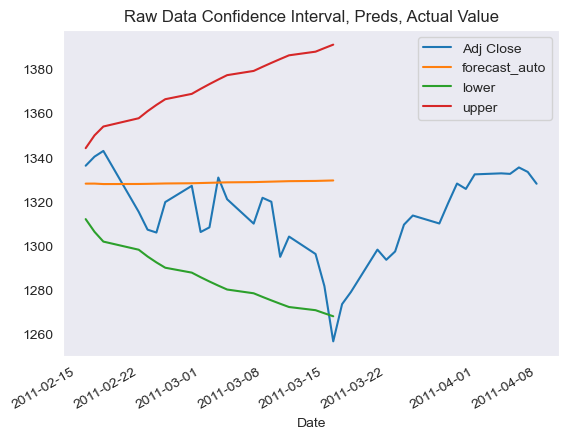

In [43]:
# Plotting 20 days of predictions with the accompanying confidence interval
forecast_test_auto = auto_arima.predict(n_periods=20)
price["forecast_auto"] = [None] *len(X_train) + list(forecast_test_auto) + [None]* (len(X_test)-20)
price["lower"] = [None] *len(X_train) + list(lower) + [None]* (len(X_test)-20)

price["upper"] = [None] *len(X_train) + list(upper) + [None]* (len(X_test)-20)


price.loc['2011-02-16':'2011-04-08'].plot(title="Raw Data Confidence Interval, Preds, Actual Value");

# Another model, Creating a TRAIN TEST Split using pmdarima terms

### p,d,q = (3,1,0)

In [45]:
# Determine the split point
split_point = int(len(df["Adj Close"]) * 0.8)
split_point

11707

In [46]:
# splitting the data
train_data = df["Adj Close"][:split_point]
test_data = df["Adj Close"][split_point:]

# Fit the ARIMA model on the training data
model = ARIMA(train_data, order=(3, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                11707
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -41232.085
Date:                Tue, 14 Nov 2023   AIC                          82472.169
Time:                        19:51:28   BIC                          82501.640
Sample:                             0   HQIC                         82482.067
                              - 11707                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0775      0.003    -22.268      0.000      -0.084      -0.071
ar.L2         -0.0410      0.003    -12.099      0.000      -0.048      -0.034
ar.L3          0.0081      0.004      2.210      0.027       0.001       0.015
sigma2        67.1517      0.273    245.847      0.000      66.616      67.687
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            186068.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             381.15   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plotting the predictions without incorporating updated data

In [47]:
# Returns 95% confidence intervals for values as well as mean prediction value
fc = results.get_forecast(len(X_test))

In [48]:
lower_int = fc.conf_int()['lower Adj Close']
upper_int = fc.conf_int()["upper Adj Close"]

In [49]:
forecast_values = fc.predicted_mean

In [50]:
full_forecast = pd.Series(([None] * len(train_data) + list(forecast_values)), index=df.index)
full_lower = pd.Series(([None] * len(train_data) + list(lower_int)), index=df.index)
full_upper = pd.Series(([None] * len(train_data) + list(upper_int)), index=df.index)

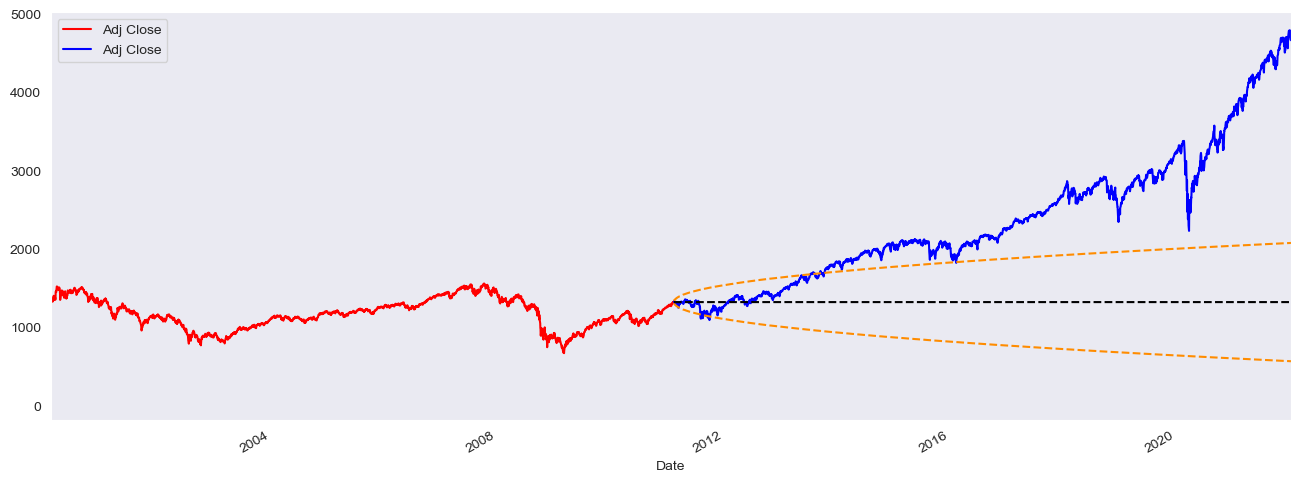

In [51]:
fig, ax = plt.subplots(figsize=(16,6))
X_train.plot(color="red", ax=ax)
X_test.plot(color="blue", ax=ax)
full_lower.plot(color="darkorange", linestyle="--")
full_upper.plot(color="darkorange", linestyle="--")
full_forecast.plot(color="black", linestyle="--")
ax.set_xlim(11000, 19000)
plt.legend();

### ARIMA for long-term predictions looks pretty bad.
While the data remain within the confidence interval for a period of what appears to be a year, the confidence interaval no longer holds any bearing on future performance once it is broken out of to the upside. 

# Continuous Updates:
This section of the notebook will continuously update the input data for the ARIMA model, and have it predict one day into the future at a time. While these results may look like an improvement, the predictive value is still very low. 
### Loop to update the training data

In [55]:
# converting to list format for easier appending of train data
train = list(X_train)
test = list(X_test)

In [56]:
# cell takes several minutes to run, too long for the value 

model_predictions = []
for i in range(len(X_test)):
    model = ARIMA(train, order=(3,1,0) )
    model_fit = model.fit()
    output = model_fit.forecast()
    y_hat = list(output)
    model_predictions.append(y_hat)
    actual_test_value = test[i]
    train.append(actual_test_value)

In [57]:
# convert the single forecast values into a series for plotting
preds_series = pd.DataFrame(model_predictions, index=X_test.index)

In [58]:
# re-formatting the series
preds_series.rename(columns={0:"Predicted Close"}, inplace=True)

### Zoomed out updated model
Due to the wide angle, the ARIMA model seems to be tracking the price quite well. By providing it with an additional true value prior to predicting, the model's forecasts look much better. This is partially misleading, especially because it is only predicting one day at a time, and then being updated with the ACTUAL test data point.

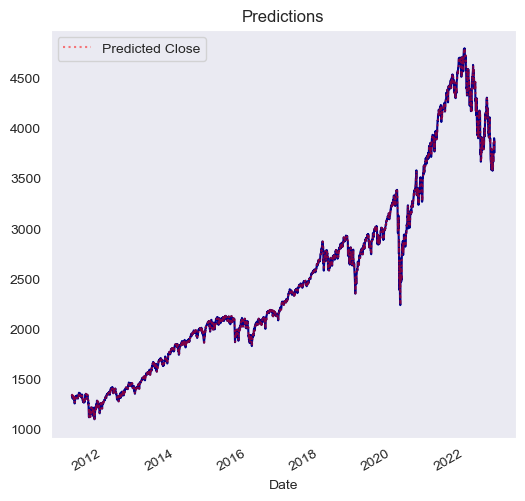

In [59]:
# Wide angle comparison
fig, ax = plt.subplots(figsize=(6,6))
X_test.plot(ax=ax, color="darkblue")
preds_series.plot(ax=ax, title="Predictions", legend=True, linestyle=":", alpha=.5, color="red");

### While it may look like a good fit, if we zoom in, you can see what is actually going on more specifically
Even by constantly updating our model with the most recent data, the "predictions" are closer to lagged "reactions" to the updated data, and they seem to be a mere rendering of the value for the moving average. This is the product of continually optimized training data.

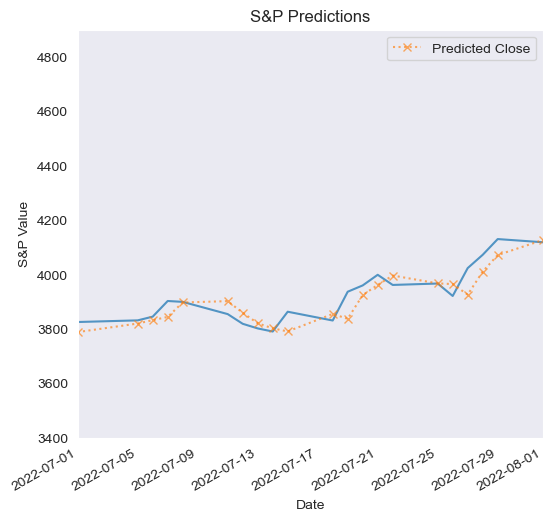

In [61]:
# Zoomed in predictions

fig, ax = plt.subplots(figsize=(6,6))
X_test.plot(ax=ax, alpha=.75)
preds_series.plot(ax=ax, title="S&P Predictions", legend=True, marker = "x", linestyle=":", alpha=.65)
ax.set_xlim('2022-07-01', '2022-08-01')
ax.set_ylim(3400, 4900)
ax.set_ylabel("S&P Value");

# New model with much longer time memory

In [62]:
model = ARIMA(X_train, order=(39, 1, 0))
results = model.fit()

In [63]:
# Get 20 days worth of predictions
fc = results.get_forecast(20)
lower_int = list(fc.conf_int()['lower Adj Close'])
upper_int = list(fc.conf_int()["upper Adj Close"])

In [64]:
# Displaying that different methods can access the same information
results.forecast(steps=20) == fc.predicted_mean

11707    True
11708    True
11709    True
11710    True
11711    True
11712    True
11713    True
11714    True
11715    True
11716    True
11717    True
11718    True
11719    True
11720    True
11721    True
11722    True
11723    True
11724    True
11725    True
11726    True
Name: predicted_mean, dtype: bool

### Converting the data for plotting 

In [65]:
preds = pd.DataFrame(list(fc.predicted_mean), index = X_test.iloc[:20].index, columns=["Predicted Value"])

In [66]:
lower_band = pd.DataFrame(lower_int, index = X_test.iloc[:20].index, columns=["Lower Confidence Value"])
upper_band = pd.DataFrame(upper_int, index = X_test.iloc[:20].index, columns=["Upper Confidence Value"])

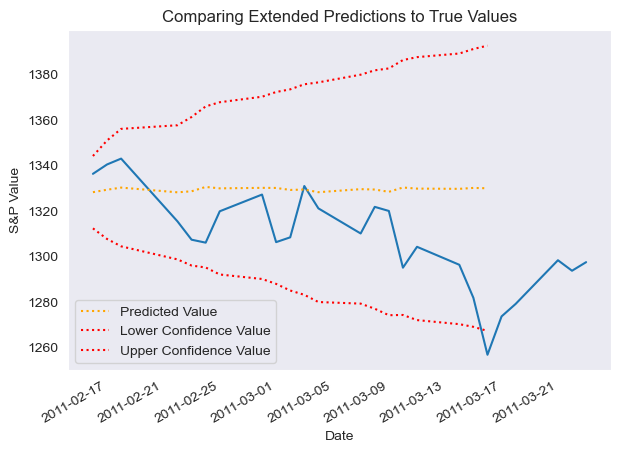

In [67]:
fig, ax = plt.subplots(figsize=(7,5))
X_test.iloc[:25].plot(ax=ax)
preds.plot(ax=ax, color="orange", linestyle=":")
lower_band.plot(ax=ax, color='red', linestyle=":")
upper_band.plot(ax=ax, color='red', linestyle=":", title="Comparing Extended Predictions to True Values")
ax.set_ylabel("S&P Value");

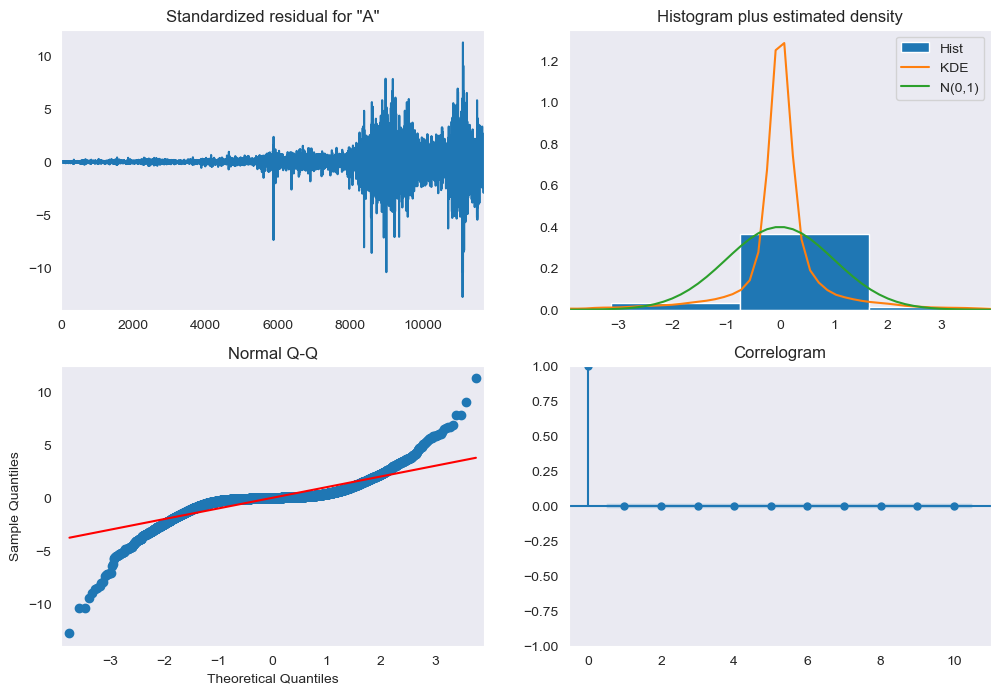

In [68]:
# Displays model characteristics
results.plot_diagnostics(fig=plt.figure(figsize=(12,8)));

### Additional plot of model forecast

In [70]:
prds = results.get_prediction(start="2011-02-09", end='2011-02-15')

In [72]:
pd.DataFrame(prds.predicted_mean)

,predicted_mean
Date,
2011-02-09,1323.996372
2011-02-10,1319.682904
2011-02-11,1322.127558
2011-02-14,1329.139573
2011-02-15,1330.613759


### Showing predicted mean of train data, forecasts of future data, lack of usefulness

In [73]:
forecast_x = pd.DataFrame([None]*len(X_train) + (list(results.forecast(steps=100))), index=list(X_train.index) + list(X_test.index[:100]))

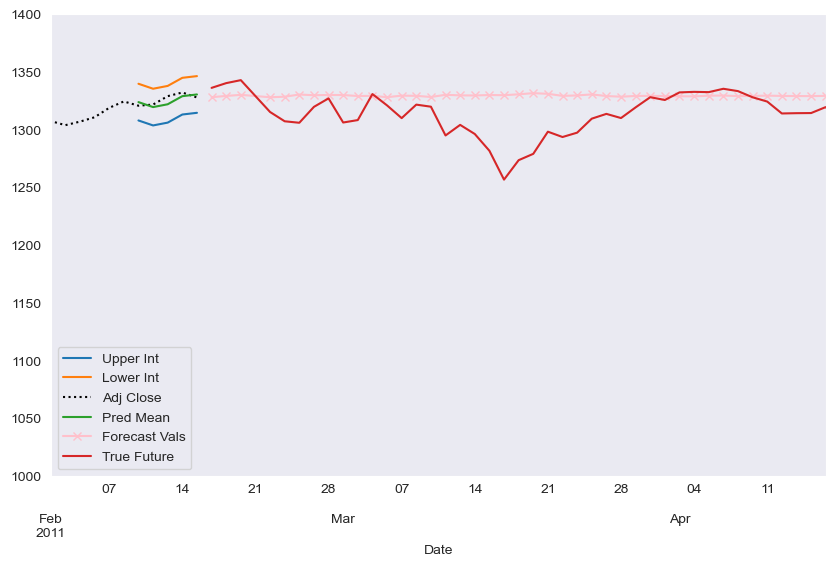

In [74]:
# comparing longer "p" model vs test data without updated training

fig, ax = plt.subplots(figsize=(10,6))
prds.conf_int().plot(ax=ax)
X_train.plot(ax=ax, color="black", linestyle=":")
pd.DataFrame(prds.predicted_mean).plot(ax=ax)
forecast_x.plot(ax=ax, color="pink", marker="x")
X_test[:100].plot(ax=ax)
ax.set_xlim("2011-02-01", '2011-04-15')
ax.set_ylim(1000,1400)
plt.legend(["Upper Int", "Lower Int", "Adj Close", "Pred Mean", "Forecast Vals", "True Future"]);

# Test metrics for the first 100 Days of Predictions
These metrics are better than I would have expected, however there is an element of chance here, as the chart reverts to the price it was at when the training data ended, therefore the predicted mean coincidentally matches the true values, even though the forecast doesn't capture the contour at all. 

In [75]:
mean_squared_error(X_test[:100], list(results.forecast(steps=100)))

799.0550863167101

In [76]:
mean_absolute_error(X_test[:100], list(results.forecast(steps=100)))

22.000227877643983

In [78]:
mean_absolute_percentage_error(X_test[:100], list(results.forecast(steps=100)))

0.01691059222371869

### This plot is exactly like the for loop updated model
These are the regressed forecast values on our training data. The model has the benefit of perfect information here.

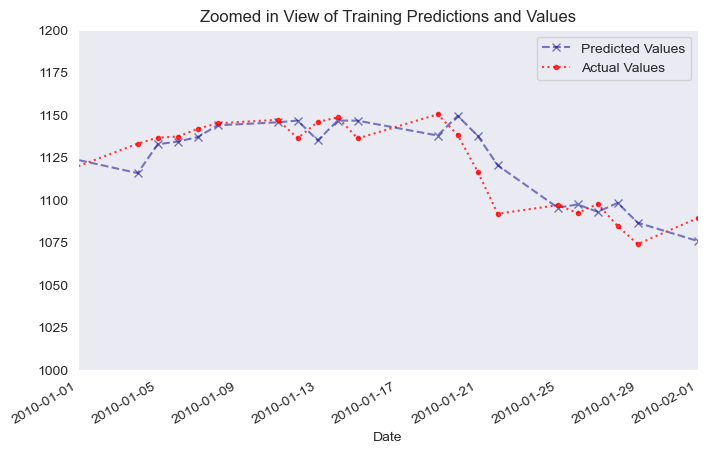

In [79]:
# Plotting regressed line on training data

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(results.fittedvalues, color="darkblue", linestyle="--", marker="x", alpha=.5)
X_train.plot(alpha = .75, marker=".", linestyle=":", color="red")
ax.set_xlim("2010-01-01", "2010-02-01")
ax.set_ylim(1000, 1200)
ax.legend(["Predicted Values", "Actual Values"])
ax.set_title("Zoomed in View of Training Predictions and Values");

### Shorter AR term for demonstration purposes

In [842]:
model = ARIMA(endog=X_train, order=(3,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                11707
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -41232.085
Date:                Sat, 11 Nov 2023   AIC                          82472.169
Time:                        13:48:21   BIC                          82501.640
Sample:                             0   HQIC                         82482.067
                              - 11707                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0775      0.003    -22.268      0.000      -0.084      -0.071
ar.L2         -0.0410      0.003    -12.099      0.000      -0.048      -0.034
ar.L3          0.0081      0.004      2.210      0.027       0.001       0.015
sigma2        67.1517      0.273    245.847      0.000      66.616      67.687
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            186068.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             381.15   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Conclusions

The ARIMA model seems to lack the sophistication to actually track the contours and make complex predictions about market values. What it appears to rely on instead is a basic simple moving average and confidence intervals. I do not see a lot of value in using this model to predict prices. The value that the model does possess is interpretability. By looking at the results summary for the model. For every lag period, we can ascribe a coefficient and therefore provide some sort of assessment on how much a price with `t` lag affects the price today. In the above summary example, we can observe that the coefficients for time lags of 1, 2, and 3 days are all statistically significant and have coefficients that are not too terribly close to zero, meaning that they have tangible impact on the prices of today. With all of that taken into account, the day to day trading of the market is too noisy to predict using this model, and I do not feel that it provides much insight or predictive value. 